# **Analysis of IMDB Data**

We will analyze a subset of IMDB's actors, genres, movie actors, and movie ratings data. This dataset comes to us from Kaggle (https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset) although we have taken steps to pull this data into a publis s3 bucket: 

* s3://cis9760-lecture9-movieanalysis/name.basics.tsv ---> (actors)
* s3://cis9760-lecture9-movieanalysis/title.basics.tsv ---> (genres)
* s3://cis9760-lecture9-movieanalysis/title.principals.tsv ---> (movie actors)
* s3://cis9760-lecture9-movieanalysis/title.ratings.tsv ---> (movie ratings)

## **Content**

**<br />name.basics.tsv.gz – Contains the following information for names:**
<br />nconst (string) - alphanumeric unique identifier of the name/person.
<br />primaryName (string)– name by which the person is most often credited.
<br />birthYear – in YYYY format.
<br />deathYear – in YYYY format if applicable, else .
<br />primaryProfession (array of strings)– the top-3 professions of the person.
<br />knownForTitles (array of tconsts) – titles the person is known for.
<br/><br/>
**<br />title.basics.tsv.gz - Contains the following information for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc).
<br />primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release.
<br />originalTitle (string) - original title, in the original language.
<br />isAdult (boolean) - 0: non-adult title; 1: adult title.
<br />startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year.
<br />endYear (YYYY) – TV Series end year. for all other title types.
<br />runtimeMinutes – primary runtime of the title, in minutes.
<br />genres (string array) – includes up to three genres associated with the title.
<br/><br/>
**<br />title.principals.tsv – Contains the principal cast/crew for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />ordering (integer) – a number to uniquely identify rows for a given titleId.
<br />nconst (string) - alphanumeric unique identifier of the name/person.
<br />category (string) - the category of job that person was in.
<br />job (string) - the specific job title if applicable, else.
<br />characters (string) - the name of the character played if applicable, else.
<br/><br/>
**<br />title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />averageRating – weighted average of all the individual user ratings.
<br />numVotes - number of votes the title has received.

## **PART 1 - Installation and Initial Setup**

In [1]:
%%info

In [2]:
# sc: spark context
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1701114732974_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- ----------
aws-cfn-bootstrap          2.0
beautifulsoup4             4.9.3
boto                       2.49.0
click                      8.1.7
docutils                   0.14
jmespath                   1.0.1
joblib                     1.3.2
lockfile                   0.11.0
lxml                       4.9.3
mysqlclient                1.4.2
nltk                       3.8.1
nose                       1.3.4
numpy                      1.20.0
pip                        20.2.2
py-dateutil                2.2
pystache                   0.5.4
python-daemon              2.2.3
python37-sagemaker-pyspark 1.4.2
pytz                       2023.3
PyYAML                     5.4.1
regex                      2021.11.10
setuptools                 28.8.0
simplejson                 3.2.0
six                        1.13.0
tqdm                       4.66.1
wheel                      0.29.0
windmill                   1.6


In [3]:
# let's install the packages we need: 
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Importing all the necessary libraries.

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc, avg, col, split, explode, array_contains, collect_list, expr, when
from pyspark.sql.types import DoubleType

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## **Loading Data**

Load all data from S3 into Spark dataframe objects

In [5]:
# Actors Dataframe
actors = spark.read.csv('s3://cis9760-lecture9-movieanalysis/name.basics.tsv', sep=r'\t', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Genres Dataframe
genres = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.basics.tsv', sep=r'\t', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Movie_Actors Dataframe
movie_actors = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.principals.tsv', sep=r'\t', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Movie_Ratings Dataframe
movie_ratings = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.ratings.tsv', sep=r'\t', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### **Actors**

In [9]:
actors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)

In [10]:
result = actors.select('primaryName', 'birthYear', 'deathYear', 'knownForTitles').limit(5)
result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------+---------+--------------------+
|    primaryName|birthYear|deathYear|      knownForTitles|
+---------------+---------+---------+--------------------+
|   Fred Astaire|     1899|     1987|tt0050419,tt00531...|
|  Lauren Bacall|     1924|     2014|tt0071877,tt01170...|
|Brigitte Bardot|     1934|       \N|tt0054452,tt00491...|
|   John Belushi|     1949|     1982|tt0077975,tt00725...|
| Ingmar Bergman|     1918|     2007|tt0069467,tt00509...|
+---------------+---------+---------+--------------------+

### **Genres**

In [11]:
# Display the first 10 rows with specified columns
result_genres = genres.select('titleType', 'primaryTitle', 'genres').limit(10)

# Show the result
result_genres.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+--------------------+
|titleType|        primaryTitle|              genres|
+---------+--------------------+--------------------+
|    short|          Carmencita|   Documentary,Short|
|    short|Le clown et ses c...|     Animation,Short|
|    short|      Pauvre Pierrot|Animation,Comedy,...|
|    short|         Un bon bock|     Animation,Short|
|    short|    Blacksmith Scene|        Comedy,Short|
|    short|   Chinese Opium Den|               Short|
|    short|Corbett and Court...|         Short,Sport|
|    short|Edison Kinetoscop...|   Documentary,Short|
|    movie|          Miss Jerry|             Romance|
|    short| Exiting the Factory|   Documentary,Short|
+---------+--------------------+--------------------+

In [12]:
# Display unique categories for the titleType column
unique_categories = genres.select('titleType').distinct()

# Show the result
unique_categories.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|       movie|
|   videoGame|
|   tvSpecial|
|       video|
|     tvMovie|
|   tvEpisode|
|     tvShort|
|       short|
+------------+

In [13]:
# Display the schema
genres.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

### **Movie Actors**

In [14]:
# Display the schema
movie_actors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)

In [15]:
# Display the first 10 rows
movie_actors.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
|tt0000003|       1|nm0721526|       director|                  \N|         \N|
|tt0000003|       2|nm5442194|       producer|            producer|         \N|
|tt0000003|       3|nm1335271|       composer|                  \N|         \N|
|tt0000003|       4|nm5442200|         editor|                  \N|         \N|
|tt0000004|       1|nm0721526|       dir

### **Movie Ratings**

In [16]:
# Display the schema
movie_ratings.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)

In [17]:
# Show the first 10 rows in descending order by the number of votes
movie_ratings.orderBy(desc("numVotes")).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt7430722|          6.8|    9999|
|tt4445154|          8.1|    9997|
|tt2229907|          6.3|    9996|
|tt0294097|          8.0|    9994|
|tt0264734|          6.5|    9993|
|tt2032572|          5.2|    9991|
|tt8860450|          6.3|    9991|
|tt0696544|          8.2|     999|
|tt2171651|          7.8|     999|
|tt0664505|          8.4|     999|
+---------+-------------+--------+
only showing top 10 rows

## **Overview of Data**

Display the number of rows and columns in each dataFrame object.

In [18]:
# Display number of columns and rows for each DataFrame
def display_info(df, table_name):
    num_columns = len(df.columns)
    num_rows = df.count()

    print(f"Number of columns in {table_name} table: {num_columns}")
    print(f"Number of rows in {table_name} table: {num_rows}")
    print("\n")

# Display information for each DataFrame
display_info(actors, "Actors")
display_info(genres, "Genres")
display_info(movie_actors, "Movie Actors")
display_info(movie_ratings, "Movie Ratings")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in Actors table: 6
Number of rows in Actors table: 9706922


Number of columns in Genres table: 9
Number of rows in Genres table: 6321302


Number of columns in Movie Actors table: 6
Number of rows in Movie Actors table: 36468817


Number of columns in Movie Ratings table: 3
Number of rows in Movie Ratings table: 993153

## **PART 2 - Analyzing Genres**

In [19]:
# Split the genres column into an array of genres and selectExpr to explode
genres_association = genres.selectExpr('tconst', 'titleType', 'explode(split(genres, ",")) as genre')

# Show the result
genres_association.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+-----------+
|   tconst|titleType|      genre|
+---------+---------+-----------+
|tt0000001|    short|Documentary|
|tt0000001|    short|      Short|
|tt0000002|    short|  Animation|
|tt0000002|    short|      Short|
|tt0000003|    short|  Animation|
+---------+---------+-----------+
only showing top 5 rows

In [20]:
# Show the first 10 rows of the association table
genres_association.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+-----------+
|   tconst|titleType|      genre|
+---------+---------+-----------+
|tt0000001|    short|Documentary|
|tt0000001|    short|      Short|
|tt0000002|    short|  Animation|
|tt0000002|    short|      Short|
|tt0000003|    short|  Animation|
|tt0000003|    short|     Comedy|
|tt0000003|    short|    Romance|
|tt0000004|    short|  Animation|
|tt0000004|    short|      Short|
|tt0000005|    short|     Comedy|
+---------+---------+-----------+
only showing top 10 rows

### **Total Unique Genres**

**What is the total number of unique genres available in the movie category?**

In [21]:
# Extract genres from the association table
unique_genres = genres_association.select('genre').distinct()

# Count the number of unique genres
total_unique_genres = unique_genres.count()

# Show the result
total_unique_genres

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

29

**What are the unique genres available?**

In [22]:
# Extract unique genres from the association table
unique_genres = genres_association.select('genre').distinct()

# Show the result
unique_genres.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|genre      |
+-----------+
|Mystery    |
|Musical    |
|Sport      |
|Action     |
|Talk-Show  |
|Romance    |
|Thriller   |
|\N         |
|Reality-TV |
|Family     |
|Fantasy    |
|History    |
|Animation  |
|Film-Noir  |
|Short      |
|Sci-Fi     |
|News       |
|Drama      |
|Documentary|
|Western    |
+-----------+
only showing top 20 rows

**Oops! Something is off!**

In [23]:
# Extract unique genres from the association table excluding "\N"
unique_genres = genres_association.filter(genres_association.genre != "\\N").select('genre').distinct()

# Show the result with top 20 genres
unique_genres.show(20, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|genre      |
+-----------+
|Mystery    |
|Musical    |
|Sport      |
|Action     |
|Talk-Show  |
|Romance    |
|Thriller   |
|Reality-TV |
|Family     |
|Fantasy    |
|History    |
|Animation  |
|Film-Noir  |
|Short      |
|Sci-Fi     |
|News       |
|Drama      |
|Documentary|
|Western    |
|Comedy     |
+-----------+
only showing top 20 rows

**Revised: What is the total number of unique genres available in the movie category?**

In [24]:
# Count the number of unique genres
total_unique_genres = unique_genres.count()

# Show the result
total_unique_genres

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

28

### **Top Genres by Movies**

Now let's find the highest rated genres in this dataset by rolling up genres.

#### **Average Rating / Genre**

First, lets join our two dataframes (movie ratings and genres) by tconst.

In [25]:
# Join the movie_ratings and genres dataframes on tconst
joined_data = movie_ratings.join(genres_association, movie_ratings.tconst == genres_association.tconst)

# Select only the desired columns
result = joined_data.select("genre", "averageRating")

# Show the first 10 rows of the result
result.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------+
|    genre|averageRating|
+---------+-------------+
|Animation|          6.4|
|    Short|          6.4|
|    Drama|          7.1|
|    Short|          7.1|
|   Action|          5.9|
|  Fantasy|          6.4|
|   Horror|          6.4|
|   Comedy|          7.0|
|   Horror|          7.0|
|    Short|          7.0|
+---------+-------------+
only showing top 10 rows

##### Now let's aggregate along the averageRating column to get a resultant dataframe that displays average rating per genre.

In [26]:
# Group by genre and calculate the average rating
average_ratings_per_genre = joined_data.groupBy('genre').agg(avg('averageRating').alias('averageRating'))

# Exclude rows where 'genre' is "\N"
average_ratings_per_genre = average_ratings_per_genre.filter(col('genre') != "\\N")

# Show the result
average_ratings_per_genre.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|genre      |averageRating     |
+-----------+------------------+
|Mystery    |7.215679885737241 |
|Musical    |6.544660194174757 |
|Action     |6.95102943855904  |
|Sport      |6.995047301057318 |
|Talk-Show  |6.5984121590312315|
|Romance    |6.78424816362804  |
|Thriller   |6.312686079259711 |
|Reality-TV |6.838867003894538 |
|Family     |6.989731258092649 |
|Fantasy    |7.093731229320441 |
|History    |7.304633656741387 |
|Animation  |7.046786054557056 |
|Film-Noir  |6.636246786632391 |
|Short      |6.799363498526124 |
|Sci-Fi     |6.747496248735035 |
|News       |6.467539496781745 |
|Drama      |7.018453629522856 |
|Documentary|7.2417405764966745|
|Western    |7.109783409459261 |
|Comedy     |6.919198961910334 |
+-----------+------------------+
only showing top 20 rows

### **Horizontal Bar Chart of Top Genres**

With this data available, let us now build a barchart of all genres

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

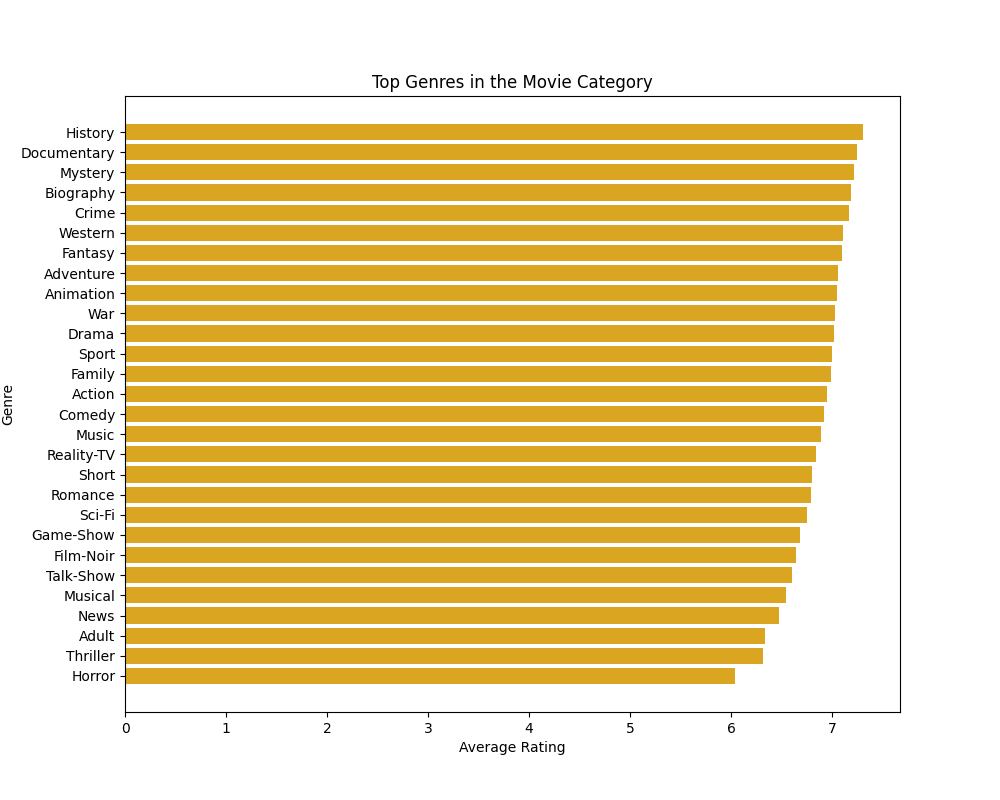

In [27]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pd_df = average_ratings_per_genre.toPandas()

# Sort the DataFrame by averageRating in descending order
pd_df = pd_df.sort_values(by='averageRating')

# Display the horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(pd_df['genre'], pd_df['averageRating'], color='goldenrod')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Top Genres in the Movie Category')
plt.show()

%matplot plt

## **PART 3 - Analyzing Job Categories**

**What is the total number of unique job categories?**

In [28]:
categories = movie_actors.limit(5).select("tconst", "category")

# Show the result
categories.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------------+
|tconst   |category       |
+---------+---------------+
|tt0000001|self           |
|tt0000001|director       |
|tt0000001|cinematographer|
|tt0000002|director       |
|tt0000002|composer       |
+---------+---------------+

In [29]:
total_unique_categories_count = movie_actors.select('category').distinct().count()

# Show the result
total_unique_categories_count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12

**What are the unique job categories available?**

In [30]:
# Select distinct categories
total_unique_categories = movie_actors.select('category').distinct()

# Show the result DataFrame
total_unique_categories.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|production_designer|
|             writer|
|              actor|
|    cinematographer|
|      archive_sound|
|    archive_footage|
|               self|
|             editor|
|           composer|
|           director|
+-------------------+

### **Top Job Categories**

Now let's find the top job categories in this dataset by rolling up categories.

#### **Counts of Titles / Job Category**

In [31]:
# Group by category and count occurrences
top_categories = movie_actors.groupBy('category').count()

# Rename the count column
top_categories = top_categories.withColumnRenamed('count', 'category_count')

# Show the result
top_categories.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------+
|category           |category_count|
+-------------------+--------------+
|actress            |6325097       |
|producer           |2197866       |
|production_designer|285924        |
|writer             |4811596       |
|actor              |8493701       |
|cinematographer    |1300404       |
|archive_sound      |2143          |
|archive_footage    |209035        |
|self               |6153089       |
|editor             |1197669       |
|composer           |1313187       |
|director           |4179106       |
+-------------------+--------------+

In [32]:
# Group by category and count occurrences, then order by count in descending order
top_categories = movie_actors.groupBy('category').count().orderBy(col('count').desc())

# Rename the count column
top_categories = top_categories.withColumnRenamed('count', 'category_count')

# Show the result
top_categories.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------+
|category           |category_count|
+-------------------+--------------+
|actor              |8493701       |
|actress            |6325097       |
|self               |6153089       |
|writer             |4811596       |
|director           |4179106       |
|producer           |2197866       |
|composer           |1313187       |
|cinematographer    |1300404       |
|editor             |1197669       |
|production_designer|285924        |
|archive_footage    |209035        |
|archive_sound      |2143          |
+-------------------+--------------+

### **Bar Chart of Top Job Categories**

With this data available, let us now build a barchart of the top 5 categories. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

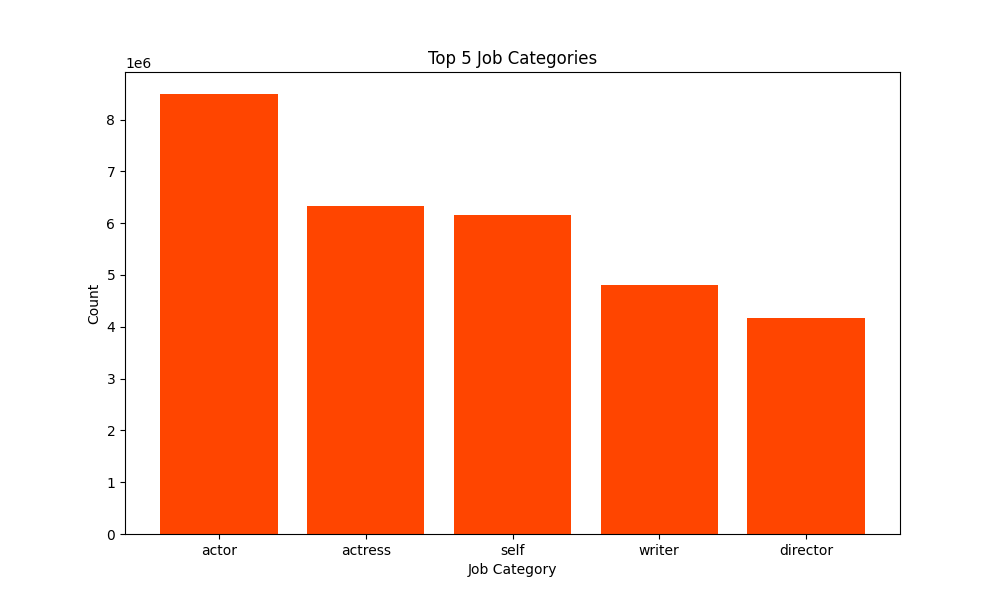

In [33]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pd_df = top_categories.limit(5).toPandas()

# Display the bar chart
plt.figure(figsize=(10, 6))
plt.bar(pd_df['category'], pd_df['category_count'], color='orangered')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.title('Top 5 Job Categories')
plt.show()

%matplot plt

## **PART 4 - Answer to the following questions:**

First join actors, genres, and movie actors and movie_reviews on each other to create new_df.

In [34]:
# Step 1: Extract unique tconsts from all three dataframes
tconsts_actors = actors.select("knownForTitles").withColumn("tconst", explode(split("knownForTitles", ","))).select("tconst").distinct()
tconsts_genres = genres.select("tconst").distinct()
tconsts_movie_actors = movie_actors.select("tconst").distinct()

# Union all unique tconsts
unique_tconsts = (tconsts_actors.union(tconsts_genres).union(tconsts_movie_actors)).distinct()

# Step 2: Add corresponding 'primaryTitle', 'titleType', and 'startYear' for each tconst from genres 
new_df = unique_tconsts.join(genres.select("tconst", "primaryTitle", "titleType", "startYear"), "tconst", "left_outer")

# Step 3: Create a column 'Actor Codes' containing 'nconst' values for each 'tconst'
actor_codes = movie_actors.groupBy("tconst").agg(collect_list("nconst").alias("Actor_Codes"))

# Step 4: Add another column named 'actor names' and 'category' from 'actors' dataframe
new_df = new_df.join(actor_codes, "tconst", "left_outer").select("tconst", "primaryTitle", "titleType", "startYear", "Actor_Codes").distinct()
new_df = new_df.withColumn("Actor_Codes", explode("Actor_Codes"))  # Explode the array to have one nconst per row
new_df = new_df.join(actors.select("nconst", "primaryName"), new_df["Actor_Codes"] == actors["nconst"], "left_outer").groupBy("tconst", "primaryTitle", "titleType", "startYear").agg(collect_list("nconst").alias("Actor_Codes"), collect_list("primaryName").alias("actor_names"))

# Step 5: Add another column named 'averageRating' from 'movie_ratings' dataframe
new_df = new_df.join(movie_ratings.select("tconst", "averageRating"), "tconst", "left_outer")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### **1) Find all the "movies" featuring "Johnny Depp" and "Helena Bonham Carter".**

In [35]:
# Specify the actors' names
actor1_name = "Johnny Depp"
actor2_name = "Helena Bonham Carter"

# Filter movies with both actors and titleType is movie
result_df = new_df.filter(
    (array_contains(new_df.actor_names, actor1_name) & array_contains(new_df.actor_names, actor2_name)) 
    & (new_df.titleType == "movie")
)

# Display the resulting dataframe
result_df.select("primaryTitle").show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------+
|primaryTitle                                  |
+----------------------------------------------+
|Charlie and the Chocolate Factory             |
|Dark Shadows                                  |
|Alice Through the Looking Glass               |
|Alice in Wonderland                           |
|Corpse Bride                                  |
|Sweeney Todd: The Demon Barber of Fleet Street|
+----------------------------------------------+

### **2) Find all the "movies" featuring "Brad Pitt" after 2010.**

In [36]:
# Specify the actor's name and the year threshold
actor_name = "Brad Pitt"
year_threshold = 2010

# Filter movies with the specified actor and after the given year
result_df = new_df.filter((array_contains(new_df.actor_names, actor_name)) & (new_df.startYear > year_threshold) & (new_df.titleType == "movie"))

# Order the results in descending order of startYear
result_df = result_df.orderBy(result_df.startYear.desc())

# Display the resulting dataframe
result_df.select("primaryTitle", "startYear").show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------+---------+
|primaryTitle                     |startYear|
+---------------------------------+---------+
|Babylon                          |2021     |
|Irresistible                     |2020     |
|Kajillionaire                    |2020     |
|Ad Astra                         |2019     |
|The King                         |2019     |
|Once Upon a Time ... in Hollywood|2019     |
|Vice                             |2018     |
|War Machine                      |2017     |
|Voyage of Time: Life's Journey   |2016     |
|Allied                           |2016     |
|The Big Short                    |2015     |
|Hitting the Apex                 |2015     |
|By the Sea                       |2015     |
|Fury                             |2014     |
|Kick-Ass 2                       |2013     |
|World War Z                      |2013     |
|12 Years a Slave                 |2013     |
|Killing Them Softly              |2012     |
|The Tree of Life                 

### **3) What is the number of "movies" "acted" by "Zendaya" per year?**

In [37]:
# Find Zendaya's nconst
zendaya_nconst = actors.filter((actors.primaryName == "Zendaya") & (actors.primaryProfession.contains("actress"))).select("nconst").first()["nconst"]

# Filter movie_actors to include only information where nconst is Zendaya's nconst and category is "actress"
zendaya_movies = movie_actors.filter((movie_actors.nconst == zendaya_nconst) & (movie_actors.category == "actress")).select("tconst")

# Extract a list of tconst applying the above filter
zendaya_movie_list = [row["tconst"] for row in zendaya_movies.collect()]

# Create a new DataFrame by filtering the genres DataFrame based on the list of tconst
zendaya_movie_genres = genres.filter(genres.tconst.isin(zendaya_movie_list) & (genres.titleType == "movie") & (col("startYear") != "\\N")).select("tconst", "startYear")

# Display a table counting tconst grouped by startYear
result_table = zendaya_movie_genres.groupBy("startYear").count().orderBy("startYear")

result_table.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|startYear|count|
+---------+-----+
|     2017|    1|
|     2018|    2|
|     2020|    1|
+---------+-----+

### **4) What are the "movies" by average rating greater than "9.7" and released in "2019"?**

In [38]:
# Specify the rating, year, and title type threshold
rating_threshold = 9.7
year_threshold = 2019
title_type_threshold = "movie"

# Filter movies with the specified rating, release year, and title type
result_df = new_df.filter((col("averageRating") > rating_threshold) & (col("startYear") == year_threshold) & (col("titleType") == title_type_threshold))

# Order the resulting DataFrame in ascending order of average rating
result_df = result_df.orderBy(col("averageRating").asc())

# Display the resulting dataframe
result_df.select("primaryTitle", "averageRating").show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------+-------------+
|primaryTitle                            |averageRating|
+----------------------------------------+-------------+
|L'Enfant Terrible                       |10.0         |
|The Butcher Baronet                     |10.0         |
|Kirket                                  |10.0         |
|Our Scripted Life                       |10.0         |
|Love in Kilnerry                        |10.0         |
|A Grunt's Life                          |10.0         |
|Bu Can Var Oldugu Sürece                |10.0         |
|A Medicine for the Mind                 |10.0         |
|Time and motion                         |9.8          |
|We Shall Not Die Now                    |9.8          |
|Gini Helida Kathe                       |9.8          |
|Randhawa                                |9.8          |
|Kamen Rider Zi-O: Over Quartzer         |9.8          |
|From Shock to Awe                       |9.8          |
|Square One                    

## **Additional Analysis**

#### **Question: What are the top 10 highest-rated movies released after 2015?**
Based on Average Ratings and Number of Votes.

In [39]:
# Convert 'startYear' to integer for filtering
genres = genres.withColumn('startYear', genres['startYear'].cast('int'))

# Join the DataFrames: Movie Ratings and Genres
joined_df = movie_ratings.join(genres, 'tconst')

# Filter for movies released after 2015 and titleType is "movie"
filtered_df = joined_df.filter((genres.startYear > 2015) & (genres.titleType == "movie"))

# Select relevant columns
result_df = filtered_df.select('primaryTitle', 'startYear', 'averageRating', 'numVotes')

# Order by average rating and vote count in descending order
result_df = result_df.orderBy(desc('averageRating'), desc('numVotes'))

# Show the top 10 highest-rated movies
result_df.show(10, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------+---------+-------------+--------+
|primaryTitle                               |startYear|averageRating|numVotes|
+-------------------------------------------+---------+-------------+--------+
|Puritan: All of Life to The Glory of God   |2019     |9.9          |8       |
|Superhombre                                |2019     |9.9          |7       |
|The Cardinal                               |2019     |9.9          |7       |
|Randhawa                                   |2019     |9.8          |816     |
|Hizam                                      |2016     |9.8          |6       |
|Kamen Rider Zi-O: Over Quartzer            |2019     |9.8          |6       |
|Internment                                 |2018     |9.8          |5       |
|Transhumance                               |2018     |9.8          |5       |
|Lumpinee                                   |2018     |9.8          |5       |
|Live The Stream: The Story of Joe Humphreys|2018   

#### **Question: What are the top 5 genres for short films by the average ratings?**

In [40]:
# Join the DataFrames
joined_df = movie_ratings.join(genres, 'tconst')

# Filter for titleType is short
joined_df = joined_df.filter(genres.titleType == "short")

# Select relevant columns
result_df = joined_df.select('genres', 'averageRating')

# Explode the genres array column
result_df = result_df.withColumn('genre', explode(split(result_df['genres'], ',')))

# Group by genre and calculate the average rating
avg_rating_by_genre = result_df.groupBy('genre').agg({'averageRating': 'mean'}).withColumnRenamed('avg(averageRating)', 'avgRating')

# Order by average rating in descending order
avg_rating_by_genre = avg_rating_by_genre.orderBy(desc('avgRating'))

# Show the top 5 genres by highest average rating
avg_rating_by_genre.show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----------------+
|genre    |avgRating        |
+---------+-----------------+
|Game-Show|9.9              |
|Talk-Show|7.276923076923077|
|Biography|7.237576219512196|
|Mystery  |7.171493803000654|
|Crime    |7.155333998005983|
+---------+-----------------+
only showing top 5 rows

#### **Which genres have the highest count of top-rated movies, defined as those within the top 25th percentile of ratings?**

In [41]:
# Convert 'averageRating' to DoubleType
movie_ratings = movie_ratings.withColumn('averageRating', movie_ratings['averageRating'].cast(DoubleType()))

# Join the DataFrames
joined_df = movie_ratings.join(genres, 'tconst')

# Filter for titleType is "movie"
joined_df = joined_df.filter(genres.titleType == "movie")

# Calculate the 25th percentile rating
percentile_25 = joined_df.approxQuantile('averageRating', [0.25], 0.01)[0]

# Create a new column to categorize movies as top-rated or not
joined_df = joined_df.withColumn('isTopRated', expr(f'averageRating >= {percentile_25}').cast('int'))

# Filter out rows with \N in the 'genres' column
joined_df = joined_df.filter(joined_df['genres'] != '\\N')

# Group by genre and count the number of top-rated movies
genre_counts = joined_df.groupBy('genres').agg({'isTopRated': 'sum'}).withColumnRenamed('sum(isTopRated)', 'topRatedCount').orderBy(desc('topRatedCount'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

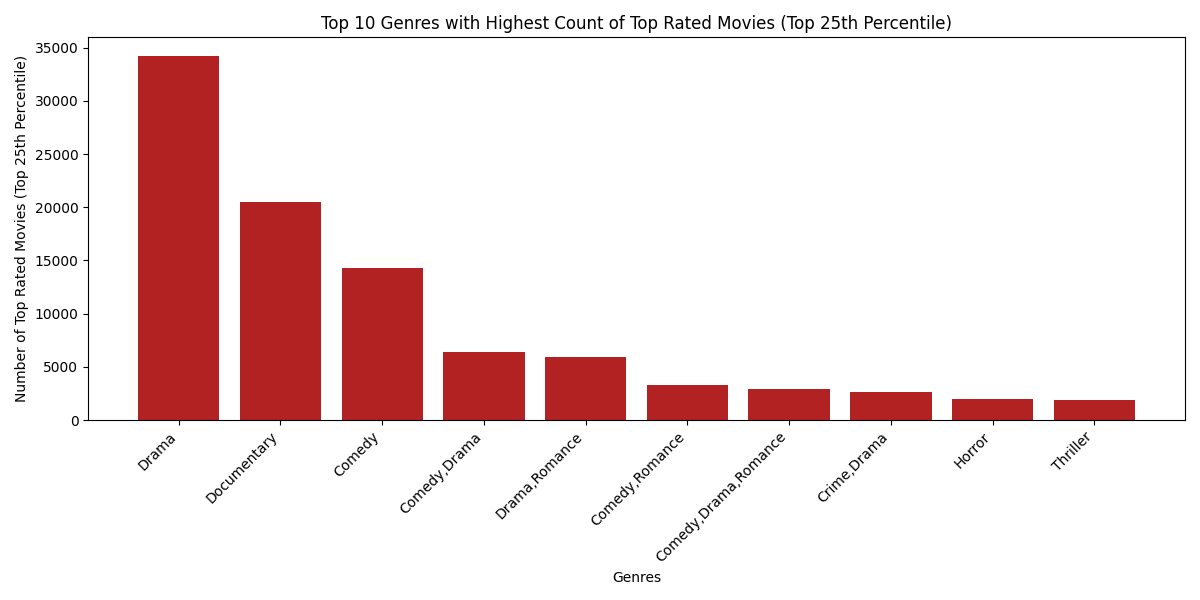

In [42]:
# Visualize the result using matplotlib for the top 10 genres

top_10_genre_counts_pd = genre_counts.limit(10).toPandas()
plt.figure(figsize=(12, 6))
plt.bar(top_10_genre_counts_pd['genres'], top_10_genre_counts_pd['topRatedCount'], color='firebrick')
plt.xlabel('Genres')
plt.ylabel('Number of Top Rated Movies (Top 25th Percentile)')
plt.title('Top 10 Genres with Highest Count of Top Rated Movies (Top 25th Percentile)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

%matplot plt

#### **Among the actors and actresses in the dataset, which 20 film professionals have the highest number of movies, and what is the count of films for each of them?**

In [43]:
# Add filter to actors DataFrame for primaryProfession being actor or actress
actors_filtered = actors.filter((actors.primaryProfession.contains("actor")) | (actors.primaryProfession.contains("actress")))

# Join the DataFrames
joined_df = movie_actors.join(actors_filtered, 'nconst')

# Add filter to genres DataFrame for titleType being movie
genres_filtered = genres.filter(genres.titleType == "movie")

# Join the filtered genres DataFrame with the already joined DataFrame
joined_df = joined_df.join(genres_filtered, 'tconst')

# Group by actor and count the number of films
actor_film_counts = joined_df.groupBy('primaryName').count().withColumnRenamed('count', 'filmCount')

# Order by film count in descending order
actor_film_counts = actor_film_counts.orderBy(desc('filmCount'))

# Show the top 20 actors with the highest number of films
top_20_actors = actor_film_counts.limit(20)
top_20_actors.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+---------+
|primaryName       |filmCount|
+------------------+---------+
|Brahmanandam      |798      |
|Adoor Bhasi       |586      |
|Matsunosuke Onoe  |565      |
|Eddie Garcia      |543      |
|Kinya Ogawa       |440      |
|Prem Nazir        |439      |
|Sung-il Shin      |411      |
|Masayoshi Nogami  |399      |
|Paquito Diaz      |391      |
|Ron Jeremy        |389      |
|Mammootty         |383      |
|Aachi Manorama    |355      |
|Bahadur           |348      |
|Mohanlal          |346      |
|Bülent Oran       |331      |
|Mithun Chakraborty|331      |
|Shivaji Ganesan   |323      |
|Yutaka Ikejima    |320      |
|Sultan Rahi       |316      |
|Tom Byron         |313      |
+------------------+---------+

#### **Visualize the 'Top 20 Actors with the Highest Number of Films'**

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

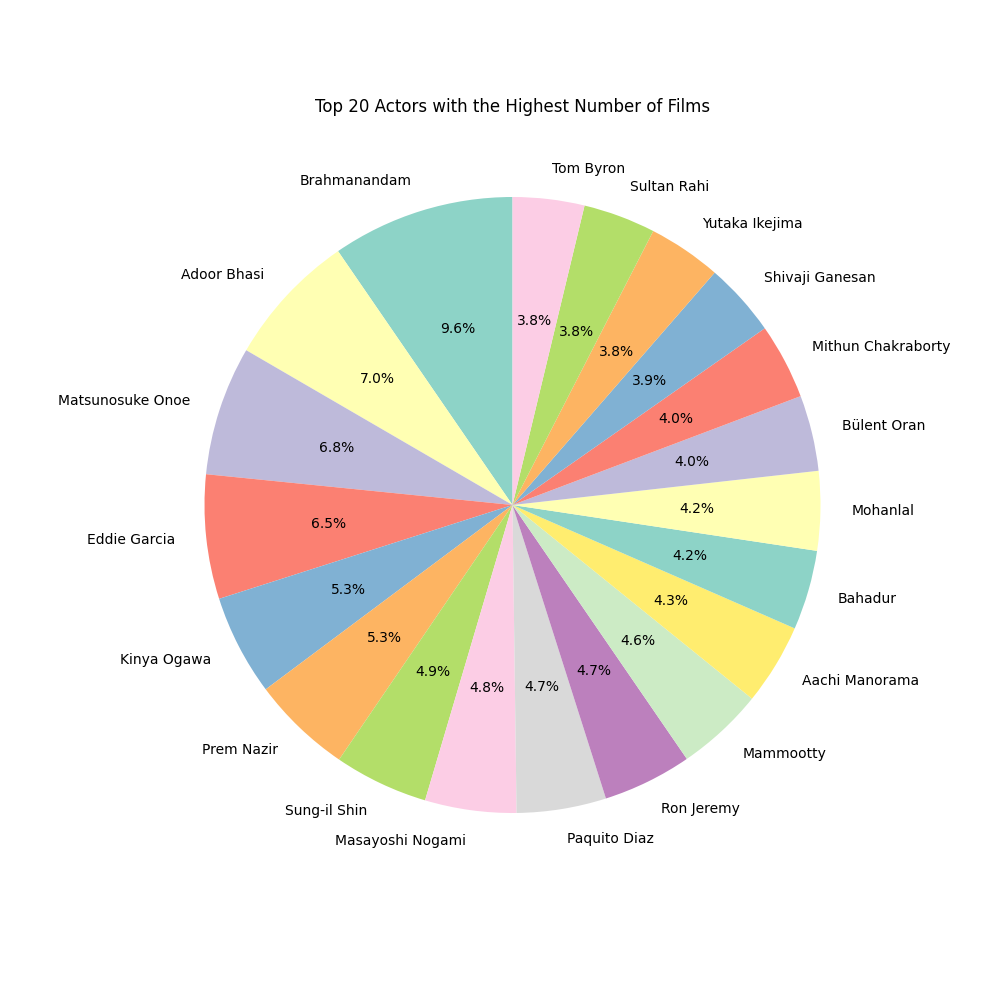

In [44]:
# Define a professional color palette (Set3)
colors = plt.cm.Set3.colors

# Convert to Pandas for easier pie chart plotting
top_20_actors_pd = top_20_actors.toPandas()

# Plotting a pie chart with the professional color palette
plt.figure(figsize=(10, 10))
plt.pie(top_20_actors_pd['filmCount'], labels=top_20_actors_pd['primaryName'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Top 20 Actors with the Highest Number of Films')
plt.show()

%matplot plt

#### **What Patterns Emerge from the Evolution of Movie Ratings Over Decades?**

In [45]:
# Define conditions for classifying movies into decades
conditions = [
    (col('startYear') < 1980),
    ((col('startYear') >= 1980) & (col('startYear') < 1990)),
    ((col('startYear') >= 1990) & (col('startYear') < 2000)),
    ((col('startYear') >= 2000) & (col('startYear') < 2010)),
    ((col('startYear') >= 2010) & (col('startYear') < 2023))
]

# Define corresponding decade labels
decade_labels = ['Pre 80s', '1980 to 1990', '1990 to 2000', '2000 to 2010', '2010 to 2023']

# Add 'decade' column based on the conditions
genres_decades = genres.withColumn('decade', when(conditions[0], decade_labels[0])
                                  .when(conditions[1], decade_labels[1])
                                  .when(conditions[2], decade_labels[2])
                                  .when(conditions[3], decade_labels[3])
                                  .when(conditions[4], decade_labels[4]))

# Join with movie_ratings
joined_df = movie_ratings.join(genres_decades, 'tconst')

# Filter out rows with null values in 'startYear' and 'averageRating'
joined_df = joined_df.filter((col('startYear').isNotNull()) & (col('averageRating').isNotNull()))

# Group by decade and calculate average rating
avg_rating_by_decade = joined_df.groupBy('decade').agg({'averageRating': 'mean'}).withColumnRenamed('avg(averageRating)', 'avgRating')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

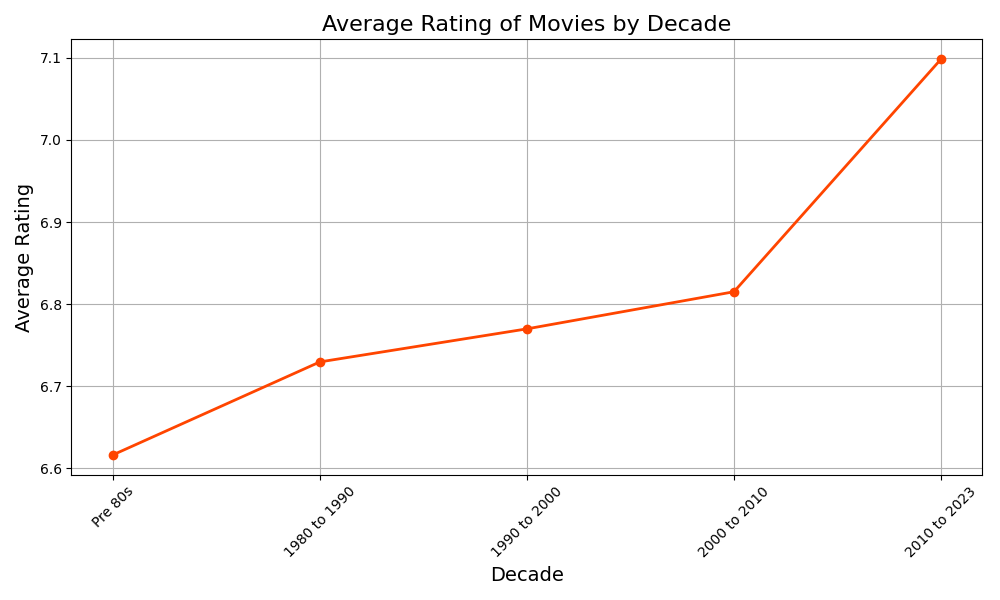

In [46]:
# Convert to Pandas DataFrame for plotting
pd_avg_rating_by_decade = avg_rating_by_decade.toPandas()

# Define the order of decades
decade_order = ['Pre 80s', '1980 to 1990', '1990 to 2000', '2000 to 2010', '2010 to 2023']

# Sort the DataFrame by decade and set the order
pd_avg_rating_by_decade['decade'] = pd.Categorical(pd_avg_rating_by_decade['decade'], categories=decade_order, ordered=True)
pd_avg_rating_by_decade = pd_avg_rating_by_decade.sort_values('decade')

# Plotting with enhanced aesthetics
plt.figure(figsize=(10, 6))
plt.plot(pd_avg_rating_by_decade['decade'], pd_avg_rating_by_decade['avgRating'], marker='o', linestyle='-', color='orangered', linewidth=2)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of Movies by Decade', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

%matplot plt

##### **The average movie ratings exhibit a discernible upward trend, reaching their peak in recent decades (2010 to 2023). This phenomenon may signify either a positive shift in audience satisfaction and cinematic quality over time or a more recent trend of inflation in ratings to attract audiences.**